# Task 2 — Classical ML vs LLMs on Structured Data (Iris)

**Date:** 2026-01-31

This notebook solves **Task 2** end-to-end on the Iris dataset and compares: 
- A **classical tree-based model** (Random Forest + an interpretable Decision Tree for rules)
- A **Transformer classifier** trained on two **textified** versions of the same structured rows
- A **local LLM** (few-shot prompting) used as a predictor, **with and without** structured guidance from the classical model

The goal is not state-of-the-art performance; it is to analyze modeling paradigms, limitations, interpretability, robustness, and practical choice tradeoffs.

## Environment & setup
This repo includes an `environment.yml` intended for `mamba`:

```bash
mamba env create -f environment.yml
mamba activate llm_structured_data
python -m ipykernel install --user --name llm_structured_data --display-name "Python (llm_structured_data)"
```

Notes:
- This notebook uses `sklearn.datasets.load_iris` (canonical Iris). If you later add the Kaggle CSV under `data/`, you can adapt the loader easily.
- Transformer / LLM sections download models from Hugging Face on first run.

In [1]:
# Core imports
import os
# Allow GPU (do not hide CUDA devices).
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")

import random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Hugging Face
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    set_seed as hf_set_seed,
 )
from datasets import Dataset

print('Torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('CUDA device:', torch.cuda.get_device_name(0))

sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', 50)

/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch: 2.10.0
CUDA available: True
CUDA device: NVIDIA RTX 2000 Ada Generation Laptop GPU


In [2]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
hf_set_seed(SEED)

@dataclass
class SplitConfig:
    test_size: float = 0.2
    val_size: float = 0.2
    random_state: int = SEED

SPLIT_CFG = SplitConfig()

## Load Iris dataset (structured)
We use the canonical Iris dataset from scikit-learn (same schema as Kaggle variant):
- 4 numeric features: sepal length/width, petal length/width
- 3 classes: setosa, versicolor, virginica

In [3]:
iris = load_iris(as_frame=True)
df = iris.frame.copy()
df.rename(columns={"target": "label_id"}, inplace=True)
label_names = list(iris.target_names)
id_to_label = {i: name for i, name in enumerate(label_names)}
label_to_id = {v: k for k, v in id_to_label.items()}
df["label"] = df["label_id"].map(id_to_label)

feature_cols = list(iris.feature_names)
target_col = "label_id"

print('Class distribution:')
display(df['label'].value_counts())
df

Class distribution:


label
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label_id,label
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


## Train / validation / test split
We use **stratified** splitting to preserve class balance in each split (important with small datasets).

In [4]:
X = df[feature_cols].copy()
y = df[target_col].copy()

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=SPLIT_CFG.test_size, random_state=SPLIT_CFG.random_state, stratify=y
)

# val_size is relative to the remaining trainval portion
val_relative = SPLIT_CFG.val_size / (1.0 - SPLIT_CFG.test_size)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_relative, random_state=SPLIT_CFG.random_state, stratify=y_trainval
)

print('Sizes:', {
    'train': len(X_train),
    'val': len(X_val),
    'test': len(X_test),
})

print('Train class counts:')
print(pd.Series(y_train).value_counts().sort_index())
print('Val class counts:')
print(pd.Series(y_val).value_counts().sort_index())
print('Test class counts:')
print(pd.Series(y_test).value_counts().sort_index())

Sizes: {'train': 90, 'val': 30, 'test': 30}
Train class counts:
label_id
0    30
1    30
2    30
Name: count, dtype: int64
Val class counts:
label_id
0    10
1    10
2    10
Name: count, dtype: int64
Test class counts:
label_id
0    10
1    10
2    10
Name: count, dtype: int64


# Task 2.1 — Classical Baseline on Structured Data
We train a **tree-based classifier** on the structured numeric features and evaluate on the held-out test set.

We use a **Random Forest** for a strong, simple baseline, and train an additional **Decision Tree** to extract human-readable rules (for later LLM augmentation).

,model,accuracy,macro_f1
0,RandomForest,0.933333,0.933333
1,RandomForest,0.933333,0.933333


Test classification report (RandomForest):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



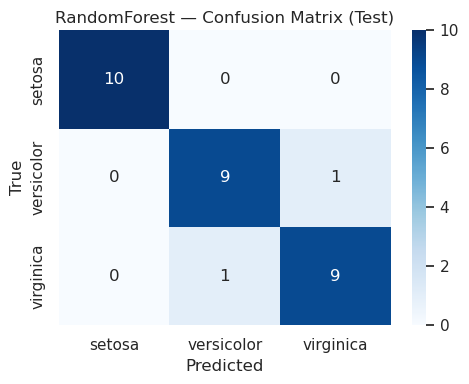

In [5]:
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=SEED,
    class_weight=None,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

def evaluate_classifier(name: str, model, X_eval: pd.DataFrame, y_eval: pd.Series) -> Dict[str, float]:
    pred = model.predict(X_eval)
    acc = accuracy_score(y_eval, pred)
    f1 = f1_score(y_eval, pred, average='macro')
    return {
        'model': name,
        'accuracy': float(acc),
        'macro_f1': float(f1),
    }

rf_val_metrics = evaluate_classifier('RandomForest', rf, X_val, y_val)
rf_test_metrics = evaluate_classifier('RandomForest', rf, X_test, y_test)
display(pd.DataFrame([rf_val_metrics, rf_test_metrics]))

rf_test_pred = rf.predict(X_test)
print('Test classification report (RandomForest):')
print(classification_report(y_test, rf_test_pred, target_names=label_names))

cm = confusion_matrix(y_test, rf_test_pred, labels=list(range(len(label_names))))
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('RandomForest — Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

,importance
petal width (cm),0.465318
petal length (cm),0.397973
sepal length (cm),0.123188
sepal width (cm),0.013520


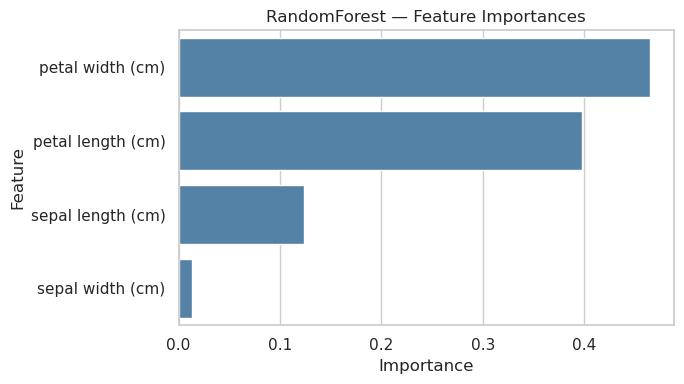

,model,accuracy,macro_f1
0,DecisionTree(max_depth=3),0.933333,0.933333


Decision tree rules (max_depth=3):
|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.65
|   |   |--- petal length (cm) <= 5.00
|   |   |   |--- class: 1
|   |   |--- petal length (cm) >  5.00
|   |   |   |--- class: 1
|   |--- petal width (cm) >  1.65
|   |   |--- class: 2

Decision tree rules (natural language, mm):
- If petal length is less or equal to 24, it is setosa.
- Else if petal length is greater than 24 and petal width is less or equal to 16, it is versicolor.
- Otherwise, it is virginica.


In [41]:
# Feature importance (RandomForest)
rf_importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
display(rf_importances.to_frame('importance'))


plt.figure(figsize=(7, 4))
sns.barplot(x=rf_importances.values, y=rf_importances.index, color='steelblue')
plt.title('RandomForest — Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Interpretable rules: fit a small Decision Tree
dt = DecisionTreeClassifier(random_state=SEED, max_depth=3)
dt.fit(X_train, y_train)
dt_test_metrics = evaluate_classifier('DecisionTree(max_depth=3)', dt, X_test, y_test)
display(pd.DataFrame([dt_test_metrics]))


rules_text = export_text(dt, feature_names=feature_cols)
print('Decision tree rules (max_depth=3):')
print(rules_text)


# Hardcoded natural-language rules in millimeters (mm), derived from the tree above
rules_nl_mm = "\n".join([
    "- If petal length is less or equal to 24, it is setosa.",
    "- Else if petal length is greater than 24 and petal width is less or equal to 16, it is versicolor.",
    "- Otherwise, it is virginica.",
])


print('Decision tree rules (natural language, mm):')
print(rules_nl_mm)

### Discussion (2.1)
In the next cell we generate a brief, **data-driven** discussion based on the actual observed metrics and importances from your run.

In [7]:
top_feats = rf_importances.head(2)
print('2.1 Discussion (auto-generated)')
print('-' * 60)
print(f"Model behavior: RandomForest achieves acc={rf_test_metrics['accuracy']:.3f}, macro-F1={rf_test_metrics['macro_f1']:.3f} on test.")
print('Feature importance: top drivers by RF importance:')
for feat, imp in top_feats.items():
    print(f"  - {feat}: {imp:.3f}")
print('Strengths: strong tabular inductive bias, works well with tiny data, fast to train, some interpretability via importances.')
print('Limitations: importance is global and can be misleading; models are not causal; decision boundaries can vary with split/seed.')

2.1 Discussion (auto-generated)
------------------------------------------------------------
Model behavior: RandomForest achieves acc=0.933, macro-F1=0.933 on test.
Feature importance: top drivers by RF importance:
  - petal width (cm): 0.465
  - petal length (cm): 0.398
Strengths: strong tabular inductive bias, works well with tiny data, fast to train, some interpretability via importances.
Limitations: importance is global and can be misleading; models are not causal; decision boundaries can vary with split/seed.


# Task 2.2 — Textification and Transformer-Based Modeling

We convert each structured row into **two** textual forms:

1) **Natural-language description**: semantically explicit and closer to typical NLP pretraining distributions.
2) **Compact semi-structured string**: preserves numeric fidelity and reduces irrelevant tokens (closer to key=value logs/records).

We fine-tune a small Transformer classifier on each representation and compare results.

Design rationale (expected effects):
- Natural language may help the model leverage linguistic priors, but can add verbosity/noise and rounding artifacts.
- Compact text may reduce noise and preserve structure, but can be out-of-distribution vs natural language pretraining.

### Why convert cm → mm in textification?
We convert the original numeric features (centimeters) into **integer millimeters** (`mm = round(cm × 10)`) for both text formats.

Motivation:
- **Removes decimal points** (e.g., `5.1 cm` → `51 mm`), which can reduce subword tokenization fragmentation (`5`, `.`, `1`) and make the input pattern more consistent for BERT-like models.
- **Keeps the same precision** used earlier (0.1 cm), so we are not adding extra information—just re-encoding it.
- Acts as a small diagnostic: if performance changes, it suggests the prior failure was partly a **tokenization / representation** issue rather than purely “Transformers can’t do tabular data.”

In [42]:
def _cm_to_mm_int(x: float) -> int:
    # Iris features are in centimeters. Converting to integer millimeters (cm * 10)
    # preserves the original 0.1 cm precision while removing decimal points,
    # which can reduce tokenization noise for subword models like BERT.
    return int(round(float(x) * 10.0))


def _format_cm(x: float) -> str:
    return f"{float(x):.1f}"


def textify_natural_cm(row: pd.Series) -> str:
    sl = _format_cm(row[feature_cols[0]])
    sw = _format_cm(row[feature_cols[1]])
    pl = _format_cm(row[feature_cols[2]])
    pw = _format_cm(row[feature_cols[3]])
    return (
        f"An iris flower has sepal length {sl}, "
        f"sepal width {sw}, "
        f"petal length {pl}, "
        f"and petal width {pw}."
    )


def textify_compact_cm(row: pd.Series) -> str:
    sl = _format_cm(row[feature_cols[0]])
    sw = _format_cm(row[feature_cols[1]])
    pl = _format_cm(row[feature_cols[2]])
    pw = _format_cm(row[feature_cols[3]])
    return (
        f"sepal_length={sl}; "
        f"sepal_width={sw}; "
        f"petal_length={pl}; "
        f"petal_width={pw}"
    )


def textify_natural_mm(row: pd.Series) -> str:
    sl = _cm_to_mm_int(row[feature_cols[0]])
    sw = _cm_to_mm_int(row[feature_cols[1]])
    pl = _cm_to_mm_int(row[feature_cols[2]])
    pw = _cm_to_mm_int(row[feature_cols[3]])
    return (
        f"An iris flower has sepal length {sl}, "
        f"sepal width {sw}, "
        f"petal length {pl}, "
        f"and petal width {pw}."
    )


def textify_compact_mm(row: pd.Series) -> str:
    sl = _cm_to_mm_int(row[feature_cols[0]])
    sw = _cm_to_mm_int(row[feature_cols[1]])
    pl = _cm_to_mm_int(row[feature_cols[2]])
    pw = _cm_to_mm_int(row[feature_cols[3]])
    return (
        f"sepal_length={sl}; "
        f"sepal_width={sw}; "
        f"petal_length={pl}; "
        f"petal_width={pw}"
    )


def textify_natural(row: pd.Series) -> str:
    return textify_natural_mm(row)


def textify_compact(row: pd.Series) -> str:
    return textify_compact_mm(row)


def textify_natural_cm_mm(row: pd.Series) -> Tuple[str, str]:
    return textify_natural_cm(row), textify_natural_mm(row)


def textify_compact_cm_mm(row: pd.Series) -> Tuple[str, str]:
    return textify_compact_cm(row), textify_compact_mm(row)


# Preview a few examples
sample_idx = df.sample(3, random_state=SEED).index
for i in sample_idx:
    row = df.loc[i]
    print('Label:', row['label'])
    print('Natural (cm):', textify_natural_cm(row))
    print('Compact (cm):', textify_compact_cm(row))
    print('Natural (mm):', textify_natural_mm(row))
    print('Compact (mm):', textify_compact_mm(row))
    print('-' * 60)

Label: versicolor
Natural (cm): An iris flower has sepal length 6.1, sepal width 2.8, petal length 4.7, and petal width 1.2.
Compact (cm): sepal_length=6.1; sepal_width=2.8; petal_length=4.7; petal_width=1.2
Natural (mm): An iris flower has sepal length 61, sepal width 28, petal length 47, and petal width 12.
Compact (mm): sepal_length=61; sepal_width=28; petal_length=47; petal_width=12
------------------------------------------------------------
Label: setosa
Natural (cm): An iris flower has sepal length 5.7, sepal width 3.8, petal length 1.7, and petal width 0.3.
Compact (cm): sepal_length=5.7; sepal_width=3.8; petal_length=1.7; petal_width=0.3
Natural (mm): An iris flower has sepal length 57, sepal width 38, petal length 17, and petal width 3.
Compact (mm): sepal_length=57; sepal_width=38; petal_length=17; petal_width=3
------------------------------------------------------------
Label: virginica
Natural (cm): An iris flower has sepal length 7.7, sepal width 2.6, petal length 6.9, a

In [43]:
def build_text_df(X_part: pd.DataFrame, y_part: pd.Series) -> pd.DataFrame:
    part = X_part.copy()
    part['label_id'] = y_part.values.astype(int)
    part['text_natural_cm'] = part.apply(lambda r: textify_natural_cm(r), axis=1)
    part['text_compact_cm'] = part.apply(lambda r: textify_compact_cm(r), axis=1)
    part['text_natural_mm'] = part.apply(lambda r: textify_natural_mm(r), axis=1)
    part['text_compact_mm'] = part.apply(lambda r: textify_compact_mm(r), axis=1)
    return part


train_text_df = build_text_df(X_train, y_train)
val_text_df = build_text_df(X_val, y_val)
test_text_df = build_text_df(X_test, y_test)


display(train_text_df[['text_natural_cm', 'text_compact_cm', 'text_natural_mm', 'text_compact_mm', 'label_id']].head())

,text_natural_cm,text_compact_cm,text_natural_mm,text_compact_mm,label_id
124,"An iris flower has sepal length 6.7, sepal wid...",sepal_length=6.7; sepal_width=3.3; petal_lengt...,"An iris flower has sepal length 67, sepal widt...",sepal_length=67; sepal_width=33; petal_length=...,2
40,"An iris flower has sepal length 5.0, sepal wid...",sepal_length=5.0; sepal_width=3.5; petal_lengt...,"An iris flower has sepal length 50, sepal widt...",sepal_length=50; sepal_width=35; petal_length=...,0
54,"An iris flower has sepal length 6.5, sepal wid...",sepal_length=6.5; sepal_width=2.8; petal_lengt...,"An iris flower has sepal length 65, sepal widt...",sepal_length=65; sepal_width=28; petal_length=...,1
23,"An iris flower has sepal length 5.1, sepal wid...",sepal_length=5.1; sepal_width=3.3; petal_lengt...,"An iris flower has sepal length 51, sepal widt...",sepal_length=51; sepal_width=33; petal_length=...,0
108,"An iris flower has sepal length 6.7, sepal wid...",sepal_length=6.7; sepal_width=2.5; petal_lengt...,"An iris flower has sepal length 67, sepal widt...",sepal_length=67; sepal_width=25; petal_length=...,2


In [44]:
def make_hf_dataset(df_part: pd.DataFrame, text_col: str) -> Dataset:
    return Dataset.from_dict({
        'text': df_part[text_col].tolist(),
        'labels': df_part['label_id'].astype(int).tolist(),
    })


ds_train_natural_cm = make_hf_dataset(train_text_df, 'text_natural_cm')
ds_val_natural_cm = make_hf_dataset(val_text_df, 'text_natural_cm')
ds_test_natural_cm = make_hf_dataset(test_text_df, 'text_natural_cm')


ds_train_compact_cm = make_hf_dataset(train_text_df, 'text_compact_cm')
ds_val_compact_cm = make_hf_dataset(val_text_df, 'text_compact_cm')
ds_test_compact_cm = make_hf_dataset(test_text_df, 'text_compact_cm')


ds_train_natural_mm = make_hf_dataset(train_text_df, 'text_natural_mm')
ds_val_natural_mm = make_hf_dataset(val_text_df, 'text_natural_mm')
ds_test_natural_mm = make_hf_dataset(test_text_df, 'text_natural_mm')


ds_train_compact_mm = make_hf_dataset(train_text_df, 'text_compact_mm')
ds_val_compact_mm = make_hf_dataset(val_text_df, 'text_compact_mm')
ds_test_compact_mm = make_hf_dataset(test_text_df, 'text_compact_mm')


len(ds_train_natural_cm), len(ds_val_natural_cm), len(ds_test_natural_cm)

(90, 30, 30)

In [11]:
# Small default model for CPU-friendly fine-tuning (will use GPU if available)
TRANSFORMER_MODELS = ['prajjwal1/bert-tiny', 'prajjwal1/bert-mini', 'prajjwal1/bert-small']

def _short_model_name(model_name: str) -> str:
    return model_name.split('/')[-1]


def _best_eval_epoch(log_history: List[Dict[str, object]]) -> Optional[float]:
    eval_rows = [
        (entry.get('eval_loss'), entry.get('epoch'))
        for entry in log_history
        if 'eval_loss' in entry
    ]
    eval_rows = [(loss, epoch) for loss, epoch in eval_rows if loss is not None and epoch is not None]
    if not eval_rows:
        return None
    eval_rows.sort(key=lambda x: x[0])
    return float(eval_rows[0][1])


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        'accuracy': float(accuracy_score(labels, preds)),
        'macro_f1': float(f1_score(labels, preds, average='macro')),
    }


def train_transformer_classifier(
    run_name: str,
    ds_train: Dataset,
    ds_val: Dataset,
    ds_test: Dataset,
    model_name: str,
    num_labels: int = 3,
    max_epochs: int = 24,
    lr: float = 5e-5,
    weight_decay: float = 0.01,
    batch_size: int = 16,
    early_stopping_patience: int = 2,
 ) -> Dict[str, object]:
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    def tok(batch):
        return tokenizer(batch['text'], truncation=True)

    ds_train_tok = ds_train.map(tok, batched=True)
    ds_val_tok = ds_val.map(tok, batched=True)
    ds_test_tok = ds_test.map(tok, batched=True)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id_to_label,
        label2id=label_to_id,
    )

    args = TrainingArguments(
        output_dir=f'./.hf_runs/{run_name}',
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=max_epochs,
        weight_decay=weight_decay,
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
        greater_is_better=False,
        logging_strategy='epoch',
        report_to=[],
        seed=SEED,
        data_seed=SEED,
    )

    collator = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_train_tok,
        eval_dataset=ds_val_tok,
        processing_class=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)],
    )

    trainer.train()

    best_val_epoch = _best_eval_epoch(trainer.state.log_history)

    val_metrics = trainer.evaluate(ds_val_tok)
    test_metrics = trainer.evaluate(ds_test_tok)

    test_logits = trainer.predict(ds_test_tok).predictions
    test_pred = np.argmax(test_logits, axis=-1)
    test_true = np.array(ds_test_tok['labels'])
    cm = confusion_matrix(test_true, test_pred, labels=list(range(num_labels)))

    return {
        'run_name': run_name,
        'model_name': model_name,
        'trainer': trainer,
        'tokenizer': tokenizer,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'test_cm': cm,
        'best_val_epoch': best_val_epoch,
    }


def run_transformer_experiment(
    rep_name: str,
    ds_train: Dataset,
    ds_val: Dataset,
    ds_test: Dataset,
    model_name: str,
    max_epochs: int,
    cmap: str,
    early_stopping_patience: int = 2,
 ) -> Tuple[Dict[str, object], Dict[str, object]]:
    run_name = f"iris_{rep_name}_{_short_model_name(model_name)}"
    run = train_transformer_classifier(
        run_name=run_name,
        ds_train=ds_train,
        ds_val=ds_val,
        ds_test=ds_test,
        model_name=model_name,
        max_epochs=max_epochs,
        early_stopping_patience=early_stopping_patience,
    )
    row = {
        'representation': rep_name,
        'model': model_name,
        'val_accuracy': run['val_metrics']['eval_accuracy'],
        'val_macro_f1': run['val_metrics']['eval_macro_f1'],
        'test_accuracy': run['test_metrics']['eval_accuracy'],
        'test_macro_f1': run['test_metrics']['eval_macro_f1'],
        'best_val_epoch': run['best_val_epoch'],
    }
    plt.figure(figsize=(5, 4))
    sns.heatmap(run['test_cm'], annot=True, fmt='d', cmap=cmap, xticklabels=label_names, yticklabels=label_names)
    plt.title(f"Transformer ({rep_name} text) — {_short_model_name(model_name)}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    return run, row

Loading weights: 100%|██████████| 39/39 [00:00<00:00, 2771.99it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight     

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.110477,1.101473,0.333333,0.166667
2,1.107500,1.099529,0.333333,0.166667
3,1.097629,1.098308,0.333333,0.166667
4,1.101994,1.097097,0.333333,0.166667
5,1.107843,1.096391,0.333333,0.166667
6,1.096789,1.095614,0.333333,0.166667
7,1.099912,1.095427,0.333333,0.166667
8,1.080747,1.094489,0.333333,0.166667
9,1.105638,1.093775,0.333333,0.166667
10,1.100919,1.092688,0.333333,0.166667


Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 60.73it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 63.20it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 62.55it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem

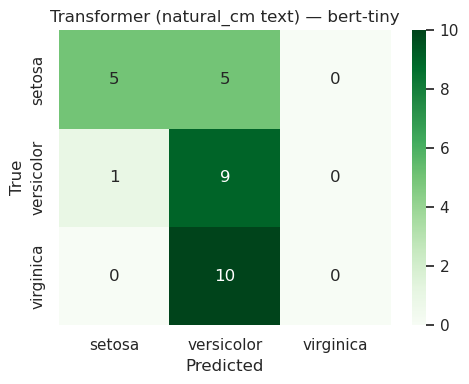

Loading weights: 100%|██████████| 71/71 [00:00<00:00, 2581.45it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-mini
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight     

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.129730,1.100836,0.333333,0.166667
2,1.093591,1.098473,0.333333,0.166667
3,1.110353,1.098069,0.333333,0.166667
4,1.100607,1.097646,0.333333,0.166667
5,1.106178,1.098136,0.333333,0.166667
6,1.101164,1.099876,0.333333,0.166667


Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 33.80it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 46.22it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 43.63it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem

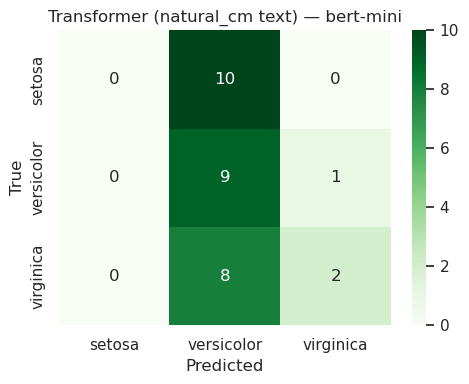

Loading weights: 100%|██████████| 71/71 [00:00<00:00, 2704.97it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-small
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight    

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.175368,1.097338,0.333333,0.166667
2,1.110857,1.100857,0.333333,0.166667
3,1.120495,1.087869,0.333333,0.166667
4,1.098155,1.051894,0.333333,0.166667
5,1.062000,0.994147,0.333333,0.166667
6,0.958606,0.780096,1.000000,1.000000
7,0.786071,0.609319,1.000000,1.000000
8,0.615756,0.477186,1.000000,1.000000
9,0.497302,0.339733,1.000000,1.000000
10,0.399273,0.202218,1.000000,1.000000


Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem

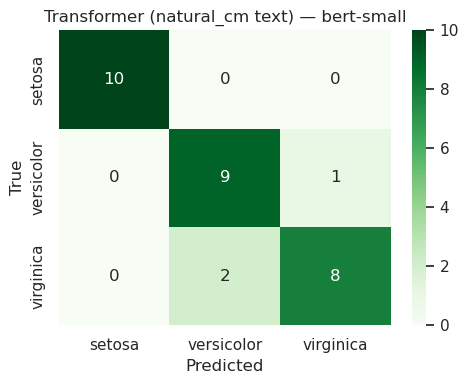

Loading weights: 100%|██████████| 39/39 [00:00<00:00, 3057.93it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight     

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.101569,1.097779,0.333333,0.166667
2,1.097648,1.097622,0.333333,0.166667
3,1.087839,1.096878,0.333333,0.180180
4,1.099066,1.096243,0.333333,0.166667
5,1.086622,1.096068,0.333333,0.166667
6,1.099292,1.096176,0.400000,0.286550
7,1.104106,1.095800,0.333333,0.166667
8,1.091876,1.095413,0.333333,0.166667
9,1.098856,1.094817,0.333333,0.166667
10,1.092700,1.093753,0.333333,0.166667


Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 100.59it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 100.71it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 108.24it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesys

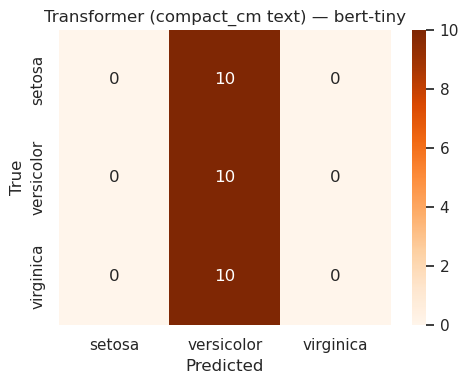

Loading weights: 100%|██████████| 71/71 [00:00<00:00, 2217.31it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-mini
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight     

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.129351,1.100896,0.333333,0.166667
2,1.111347,1.097504,0.333333,0.166667
3,1.094781,1.094413,0.366667,0.231546
4,1.107667,1.094961,0.333333,0.166667
5,1.093955,1.087377,0.333333,0.166667
6,1.090816,1.059999,0.333333,0.166667
7,1.069274,1.014169,0.500000,0.400000
8,1.030671,0.933822,0.666667,0.555556
9,0.970538,0.857215,0.666667,0.555556
10,0.858503,0.784896,0.700000,0.680000


Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 26.85it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 27.04it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 25.84it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem

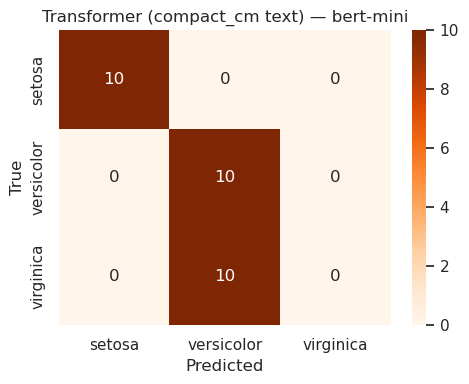

Loading weights: 100%|██████████| 71/71 [00:00<00:00, 2708.02it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-small
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight    

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.154320,1.050537,0.500000,0.412698
2,1.014933,0.877734,0.666667,0.555556
3,0.841270,0.613243,0.866667,0.861111
4,0.603702,0.441015,0.933333,0.933333
5,0.454922,0.364491,0.833333,0.822222
6,0.346779,0.280573,0.933333,0.932660
7,0.237659,0.257899,0.900000,0.899749
8,0.172448,0.236772,0.933333,0.933333
9,0.167093,0.348475,0.900000,0.899749
10,0.199477,0.274357,0.933333,0.932660


Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem

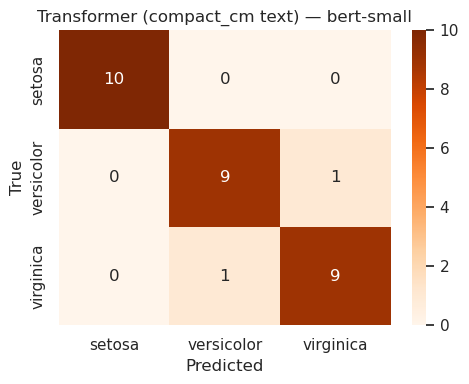

Loading weights: 100%|██████████| 39/39 [00:00<00:00, 3371.63it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight     

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.106564,1.101465,0.333333,0.166667
2,1.097208,1.100129,0.333333,0.166667
3,1.091974,1.098240,0.333333,0.166667
4,1.102151,1.097266,0.333333,0.166667
5,1.103378,1.096586,0.333333,0.166667
6,1.102919,1.096375,0.333333,0.166667
7,1.102278,1.096608,0.333333,0.166667
8,1.089952,1.095679,0.333333,0.166667
9,1.098434,1.094540,0.333333,0.166667
10,1.100020,1.093678,0.333333,0.166667


Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 113.26it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 115.12it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 105.12it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesys

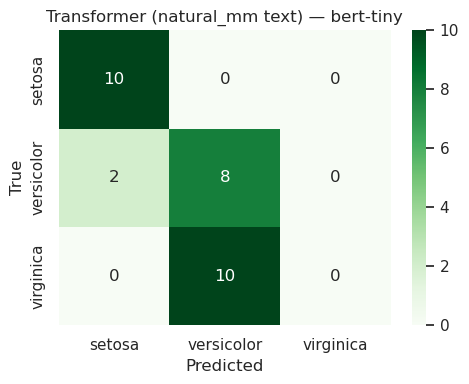

Loading weights: 100%|██████████| 71/71 [00:00<00:00, 2821.34it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-mini
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight     

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.113861,1.100322,0.333333,0.166667
2,1.091884,1.099307,0.333333,0.166667
3,1.098887,1.096750,0.333333,0.166667
4,1.098134,1.094845,0.333333,0.166667
5,1.097257,1.083875,0.333333,0.166667
6,1.093221,1.060305,0.466667,0.414006
7,1.056134,1.005165,0.733333,0.682540
8,1.000143,0.908440,0.966667,0.966583
9,0.911351,0.823051,0.900000,0.899749
10,0.842996,0.748239,0.900000,0.899749


Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 27.34it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 27.15it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 27.29it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem

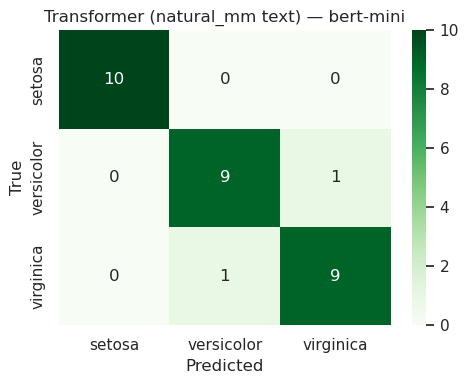

Loading weights: 100%|██████████| 71/71 [00:00<00:00, 2581.76it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-small
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight    

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.149083,1.097428,0.333333,0.166667
2,1.096060,1.089723,0.333333,0.166667
3,1.110266,1.048516,0.333333,0.166667
4,1.029256,0.904404,0.666667,0.555556
5,0.868204,0.664170,0.900000,0.899749
6,0.643225,0.470924,0.900000,0.899749
7,0.466828,0.375404,0.900000,0.899749
8,0.358803,0.365079,0.900000,0.899749
9,0.244672,0.305886,0.900000,0.899749
10,0.184840,0.337606,0.900000,0.899749


Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem

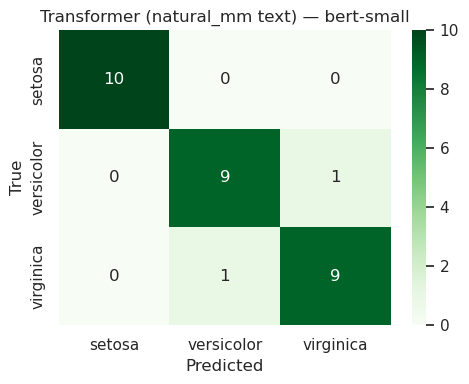

Loading weights: 100%|██████████| 39/39 [00:00<00:00, 3150.15it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight     

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.103183,1.104451,0.333333,0.166667
2,1.099709,1.101824,0.333333,0.166667
3,1.101189,1.100304,0.333333,0.166667
4,1.101197,1.097784,0.333333,0.166667
5,1.102071,1.097302,0.333333,0.166667
6,1.103154,1.096957,0.333333,0.166667
7,1.103101,1.096672,0.333333,0.170940
8,1.106076,1.095503,0.300000,0.157895
9,1.096486,1.094957,0.333333,0.166667
10,1.090378,1.094531,0.466667,0.367521


Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 107.62it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 114.68it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 110.48it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesys

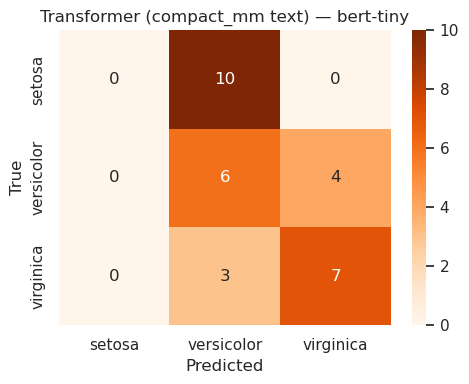

Loading weights: 100%|██████████| 71/71 [00:00<00:00, 2789.21it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-mini
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight     

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.116631,1.076097,0.333333,0.166667
2,1.065844,1.013988,0.333333,0.185185
3,0.999379,0.876741,0.666667,0.555556
4,0.897172,0.781117,0.666667,0.555556
5,0.824461,0.723934,0.666667,0.555556
6,0.735420,0.668377,0.666667,0.555556
7,0.708258,0.629171,0.666667,0.555556
8,0.648747,0.594868,0.666667,0.555556
9,0.600241,0.566674,0.733333,0.682540
10,0.574799,0.542007,0.866667,0.861111


Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 26.90it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 27.20it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 26.75it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem

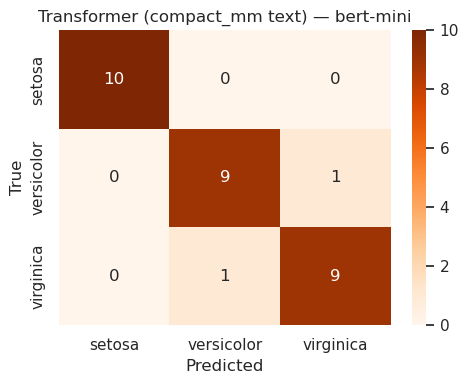

Loading weights: 100%|██████████| 71/71 [00:00<00:00, 2919.82it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-small
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight    

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.076055,0.867408,0.833333,0.829741
2,0.808029,0.597331,0.900000,0.899749
3,0.518973,0.415327,0.900000,0.899749
4,0.328020,0.335307,0.900000,0.899749
5,0.204939,0.319205,0.900000,0.899749
6,0.130224,0.328431,0.900000,0.899749
7,0.104166,0.405646,0.900000,0.899749


Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")
Writing model shards: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]
/home/mandado/.local/share/mamba/envs/llm_structured_data/lib/python3.11/site-packages/transformers/trainer.py:4181: UserWarning: mtime may not be reliable on this filesystem

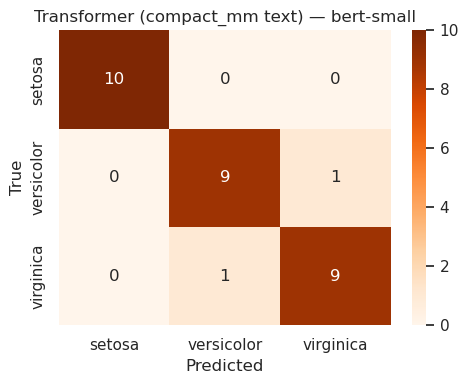

In [12]:
# Train Transformer models (bert-tiny/mini/small) on both textifications
rep_configs = [
    {
        'name': 'natural_cm',
        'ds_train': ds_train_natural_cm,
        'ds_val': ds_val_natural_cm,
        'ds_test': ds_test_natural_cm,
        'max_epochs': 24,
        'cmap': 'Greens',
    },
    {
        'name': 'compact_cm',
        'ds_train': ds_train_compact_cm,
        'ds_val': ds_val_compact_cm,
        'ds_test': ds_test_compact_cm,
        'max_epochs': 24,
        'cmap': 'Oranges',
    },
    {
        'name': 'natural_mm',
        'ds_train': ds_train_natural_mm,
        'ds_val': ds_val_natural_mm,
        'ds_test': ds_test_natural_mm,
        'max_epochs': 24,
        'cmap': 'Greens',
    },
    {
        'name': 'compact_mm',
        'ds_train': ds_train_compact_mm,
        'ds_val': ds_val_compact_mm,
        'ds_test': ds_test_compact_mm,
        'max_epochs': 24,
        'cmap': 'Oranges',
    },
 ]


transformer_runs: List[Dict[str, object]] = []
transformer_results: List[Dict[str, object]] = []


for cfg in rep_configs:
    for model_name in TRANSFORMER_MODELS:
        run, row = run_transformer_experiment(
            rep_name=cfg['name'],
            ds_train=cfg['ds_train'],
            ds_val=cfg['ds_val'],
            ds_test=cfg['ds_test'],
            model_name=model_name,
            max_epochs=cfg['max_epochs'],
            cmap=cfg['cmap'],
        )
        transformer_runs.append({
            'representation': cfg['name'],
            'model': model_name,
            'run': run,
        })
        transformer_results.append(row)


transformer_results_df = pd.DataFrame(transformer_results)

In [13]:
# Quick view: best model per representation
best_by_rep = (
    transformer_results_df.sort_values('test_macro_f1', ascending=False)
    .groupby('representation', as_index=False)
    .first()
    .loc[:, ['representation', 'model', 'test_accuracy', 'test_macro_f1', 'best_val_epoch']]
 )
display(best_by_rep)

,representation,model,test_accuracy,test_macro_f1,best_val_epoch
0,compact_cm,prajjwal1/bert-small,0.933333,0.933333,8.0
1,compact_mm,prajjwal1/bert-mini,0.933333,0.933333,19.0
2,natural_cm,prajjwal1/bert-small,0.900000,0.899749,21.0
3,natural_mm,prajjwal1/bert-small,0.933333,0.933333,9.0


In [14]:
# Compare all Transformer runs across text representations and model sizes
comparison_df = transformer_results_df.copy()
display(comparison_df.sort_values(['model', 'representation']))


best_rep = comparison_df.sort_values('test_macro_f1', ascending=False).iloc[0]['representation']
print('Best text representation by test macro-F1:', best_rep)

,representation,model,val_accuracy,val_macro_f1,test_accuracy,test_macro_f1,best_val_epoch
4,compact_cm,prajjwal1/bert-mini,0.666667,0.555556,0.666667,0.555556,24.0
10,compact_mm,prajjwal1/bert-mini,0.900000,0.899749,0.933333,0.933333,19.0
1,natural_cm,prajjwal1/bert-mini,0.333333,0.166667,0.366667,0.264726,4.0
7,natural_mm,prajjwal1/bert-mini,0.900000,0.899749,0.933333,0.933333,24.0
5,compact_cm,prajjwal1/bert-small,0.933333,0.933333,0.933333,0.933333,8.0
11,compact_mm,prajjwal1/bert-small,0.900000,0.899749,0.933333,0.933333,5.0
2,natural_cm,prajjwal1/bert-small,1.000000,1.000000,0.900000,0.899749,21.0
8,natural_mm,prajjwal1/bert-small,0.900000,0.899749,0.933333,0.933333,9.0
3,compact_cm,prajjwal1/bert-tiny,0.366667,0.231546,0.333333,0.166667,24.0
9,compact_mm,prajjwal1/bert-tiny,0.533333,0.439394,0.433333,0.360153,24.0


Best text representation by test macro-F1: natural_mm


# Discussion (2.2)

### BERT family models (tiny / mini / small)
- **Not all models collapse**: `bert-mini` and `bert-small` reach strong test macro-F1 (≈0.90–0.93) on several reps (notably `natural_mm` and `compact_mm`, and also `compact_cm` for `bert-small`).
- **Representation matters**: the best run by test macro-F1 is `natural_mm`, but `compact_mm` is also consistently strong for `bert-mini`/`bert-small`.
- **`bert-tiny` remains unstable**: it stays near chance on some reps, improving slightly on `natural_cm/mm` but still well below the larger models.
- **Early stopping shows different training dynamics**: best validation loss is reached between ~5–24 epochs depending on model/representation, indicating sensitivity to both model size and text format.
- **Numeric-text mismatch is mitigated, not eliminated**: mm encoding helps larger models, but tiny still struggles, suggesting capacity and tokenization both matter.
- **Takeaway**: modestly larger BERTs can learn useful decision boundaries even from textified numeric data, while the smallest model is too brittle for consistent performance.
- **TODO**: try with higher lr for `bert-tiny`.

# Task 2.3 — LLM-Based Prediction and Hybrid Modeling

We evaluate a **local LLM** in a **few-shot** prompting setup (no external APIs).

Implementation choices:
- Use a small instruction-tuned model via Hugging Face (`google/flan-t5-small` by default) for CPU-friendly inference.
- Few-shot prompting: include a small balanced set of labeled training examples.
- Ask the LLM to output a single class label and a short reason.

Hybrid augmentation: we inject structured information derived from the classical model:
- RandomForest feature importances (global)
- A shallow DecisionTree rule listing (interpretable)

We compare:
- LLM alone
- LLM + classical guidance

In [45]:
LLM_MODELS: List[str] = ['google/flan-t5-small', 'google/flan-t5-base', 'google/flan-t5-large']

# NOTE: transformers v5 removed the `text2text-generation` pipeline task.
# We run FLAN-T5 directly via `generate()` to keep this notebook local-only + robust.
def load_llm_model(model_name: str) -> Optional[Dict[str, object]]:
    try:
        from transformers import AutoModelForSeq2SeqLM
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        model.eval()

        def generate_fn(prompt: str, max_new_tokens: int = 60) -> str:
            print('Prompt:')
            print(prompt)
            inputs = tokenizer(
                prompt,
                return_tensors='pt',
                truncation=True,
                max_length=512,
            ).to(device)
            if (inputs['input_ids'].shape[1] >= 512):
                print('WARNING: Prompt was truncated to 512 tokens, which may cause information loss.')
            with torch.inference_mode():
                out_ids = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    do_sample=False,
                )
            if (out_ids.shape[1] <= 1):
                print('WARNING: Model did not generate any new tokens.')
            if (out_ids.shape[1] >= max_new_tokens):
                print('WARNING: Model output was truncated to max_new_tokens, which may cause information loss.')
            output = tokenizer.decode(out_ids[0], skip_special_tokens=True)
            print('Model output:')
            print(output)
            return output

        print('Loaded local LLM:', model_name, '| device:', str(device))
        return {
            'model_name': model_name,
            'tokenizer': tokenizer,
            'model': model,
            'device': device,
            'generate_fn': generate_fn,
        }
    except Exception as e:
        print('WARNING: Could not load local LLM model:', model_name)
        print('Reason:', repr(e))
        return None

In [ ]:
def label_id_to_name(label_id: int) -> str:
    return id_to_label[int(label_id)]


def normalize_label_text(text: str) -> str:
    t = text.strip().lower()
    for name in label_names:
        if name.lower() in t:
            return name
    # common variants
    if 'setosa' in t:
        return 'setosa'
    if 'versicolor' in t:
        return 'versicolor'
    if 'virginica' in t:
        return 'virginica'
    return 'unknown'


def build_fewshot_prompt(
    examples: List[Tuple[str, str]],
    query_text: str,
    guidance: Optional[str] = None,
 ) -> str:
    lines: List[str] = []
    lines.append('Task: Classify an iris flower into exactly one species: setosa, versicolor, virginica.')
    lines.append('Reply with only the species name, nothing else. Think step by step about which thresholds apply.')
    lines.append('')

    if guidance:
        lines.append('Classification rules:')
        lines.append(guidance)

    lines.append('Examples:')
    for x, y in examples:
        lines.append(f"{x} => {y}")
    lines.append('')

    lines.append(f"{query_text} =>")
    return '\n'.join(lines)


def llm_predict_label(prompt: str, generate_fn, max_new_tokens: int = 60) -> Tuple[str, str]:
    if generate_fn is None:
        return 'unknown', 'LLM not loaded'
    out = generate_fn(prompt, max_new_tokens=max_new_tokens)
    pred = normalize_label_text(out)
    return pred, out

In [51]:
# Use compact format with mm units for all LLM prompting
llm_rep = 'compact_mm'
print('Using representation for LLM prompting:', llm_rep)


train_texts = train_text_df['text_compact_mm'].tolist()
train_labels = [label_id_to_name(i) for i in train_text_df['label_id'].tolist()]
test_texts = test_text_df['text_compact_mm'].tolist()
test_labels = [label_id_to_name(i) for i in test_text_df['label_id'].tolist()]


# Balanced 3-shot: 1 example per class
fewshot_examples: List[Tuple[str, str]] = []
for cls in label_names:
    for x, y in zip(train_texts, train_labels):
        if y == cls:
            fewshot_examples.append((x, y))
            break


print('Few-shot examples:', len(fewshot_examples))
for x, y in fewshot_examples:
    print(y, '|', x)

Using representation for LLM prompting: compact_mm
Few-shot examples: 3
setosa | sepal_length=50; sepal_width=35; petal_length=13; petal_width=3
versicolor | sepal_length=65; sepal_width=28; petal_length=46; petal_width=15
virginica | sepal_length=67; sepal_width=33; petal_length=57; petal_width=21


In [52]:
# Structured guidance for LLM augmentation

# top_k = 4
# top_rf = rf_importances.head(top_k)
# importance_lines = ['Feature importances (highest first):']
# for feat, imp in top_rf.items():
#     feat_mm = feat.replace('(cm)', '(mm)')
#     importance_lines.append(f'- {feat_mm}: {imp:.3f}')


# guidance = ('\n'.join(importance_lines)
#     + '\n\nShallow decision tree rules (natural language):\n'
#     + rules_nl_mm
#  )
guidance = rules_nl_mm

print(guidance)

- If petal length is less or equal to 24, it is setosa.
- Else if petal length is greater than 24 and petal width is less or equal to 16, it is versicolor.
- Otherwise, it is virginica.


In [53]:
# LLM evaluation (unguided + guided) for each model
def _eval_llm_preds(preds: List[str], true_labels: List[str]) -> Dict[str, object]:
    pred_ids = [label_to_id.get(p, -1) for p in preds]
    true_ids = [label_to_id[t] for t in true_labels]
    mask = [p != -1 for p in pred_ids]
    known_pred_ids = np.array([p for p, m in zip(pred_ids, mask) if m])
    known_true_ids = np.array([t for t, m in zip(true_ids, mask) if m])
    acc = accuracy_score(known_true_ids, known_pred_ids) if len(known_pred_ids) else 0.0
    f1 = f1_score(known_true_ids, known_pred_ids, average='macro') if len(known_pred_ids) else 0.0
    return {
        'acc': float(acc),
        'f1': float(f1),
        'mask': mask,
        'pred_ids': pred_ids,
        'true_ids': true_ids,
    }


def run_llm_suite(model_name: str, guidance_text: str) -> Dict[str, object]:
    llm_pack = load_llm_model(model_name)
    generate_fn = None if llm_pack is None else llm_pack['generate_fn']

    def run_one(guidance: Optional[str]) -> Dict[str, object]:
        preds: List[str] = []
        raw_outs: List[str] = []
        for text in test_texts:
            prompt = build_fewshot_prompt(fewshot_examples, text, guidance=guidance)
            pred, raw = llm_predict_label(prompt, generate_fn)
            preds.append(pred)
            raw_outs.append(raw)
        metrics = _eval_llm_preds(preds, test_labels)
        return {
            'preds': preds,
            'raw': raw_outs,
            'metrics': metrics,
        }

    unguided = run_one(guidance=None)
    guided = run_one(guidance=guidance_text)

    return {
        'model': model_name,
        'unguided': unguided,
        'guided': guided,
    }


llm_results: List[Dict[str, object]] = []
for model_name in LLM_MODELS:
    res = run_llm_suite(model_name, guidance)
    llm_results.append(res)


llm_summary = []
for res in llm_results:
    llm_summary.append({
        'model': res['model'],
        'mode': 'unguided',
        'test_accuracy': res['unguided']['metrics']['acc'],
        'test_macro_f1': res['unguided']['metrics']['f1'],
        'coverage': f"{sum(res['unguided']['metrics']['mask'])}/{len(res['unguided']['metrics']['mask'])}",
    })
    llm_summary.append({
        'model': res['model'],
        'mode': 'guided',
        'test_accuracy': res['guided']['metrics']['acc'],
        'test_macro_f1': res['guided']['metrics']['f1'],
        'coverage': f"{sum(res['guided']['metrics']['mask'])}/{len(res['guided']['metrics']['mask'])}",
    })
display(pd.DataFrame(llm_summary))

Loading weights: 100%|██████████| 190/190 [00:00<00:00, 1996.65it/s, Materializing param=shared.weight]                                                       
The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Loaded local LLM: google/flan-t5-small | device: cuda
Prompt:
Task: Classify an iris flower into exactly one species: setosa, versicolor, virginica.
Reply with only the species name, nothing else.

Examples:
sepal_length=50; sepal_width=35; petal_length=13; petal_width=3 => setosa
sepal_length=65; sepal_width=28; petal_length=46; petal_width=15 => versicolor
sepal_length=67; sepal_width=33; petal_length=57; petal_width=21 => virginica

sepal_length=44; sepal_width=30; petal_length=13; petal_width=2 =>
Model output:
setosa
Prompt:
Task: Classify an iris flower into exactly one species: setosa, versicolor, virginica.
Reply with only the species name, nothing else.

Examples:
sepal_length=50; sepal_width=35; petal_length=13; petal_width=3 => setosa
sepal_length=65; sepal_width=28; petal_length=46; petal_width=15 => versicolor
sepal_length=67; sepal_width=33; petal_length=57; petal_width=21 => virginica

sepal_length=61; sepal_width=30; petal_length=49; petal_width=18 =>
Model output:
seto

Loading weights: 100%|██████████| 282/282 [00:00<00:00, 1973.06it/s, Materializing param=shared.weight]                                                       
The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Loaded local LLM: google/flan-t5-base | device: cuda
Prompt:
Task: Classify an iris flower into exactly one species: setosa, versicolor, virginica.
Reply with only the species name, nothing else.

Examples:
sepal_length=50; sepal_width=35; petal_length=13; petal_width=3 => setosa
sepal_length=65; sepal_width=28; petal_length=46; petal_width=15 => versicolor
sepal_length=67; sepal_width=33; petal_length=57; petal_width=21 => virginica

sepal_length=44; sepal_width=30; petal_length=13; petal_width=2 =>
Model output:
virginica
Prompt:
Task: Classify an iris flower into exactly one species: setosa, versicolor, virginica.
Reply with only the species name, nothing else.

Examples:
sepal_length=50; sepal_width=35; petal_length=13; petal_width=3 => setosa
sepal_length=65; sepal_width=28; petal_length=46; petal_width=15 => versicolor
sepal_length=67; sepal_width=33; petal_length=57; petal_width=21 => virginica

sepal_length=61; sepal_width=30; petal_length=49; petal_width=18 =>
Model output:
vi

Loading weights: 100%|██████████| 558/558 [00:00<00:00, 2219.93it/s, Materializing param=shared.weight]                                                       
The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Loaded local LLM: google/flan-t5-large | device: cuda
Prompt:
Task: Classify an iris flower into exactly one species: setosa, versicolor, virginica.
Reply with only the species name, nothing else.

Examples:
sepal_length=50; sepal_width=35; petal_length=13; petal_width=3 => setosa
sepal_length=65; sepal_width=28; petal_length=46; petal_width=15 => versicolor
sepal_length=67; sepal_width=33; petal_length=57; petal_width=21 => virginica

sepal_length=44; sepal_width=30; petal_length=13; petal_width=2 =>
Model output:
setosa
Prompt:
Task: Classify an iris flower into exactly one species: setosa, versicolor, virginica.
Reply with only the species name, nothing else.

Examples:
sepal_length=50; sepal_width=35; petal_length=13; petal_width=3 => setosa
sepal_length=65; sepal_width=28; petal_length=46; petal_width=15 => versicolor
sepal_length=67; sepal_width=33; petal_length=57; petal_width=21 => virginica

sepal_length=61; sepal_width=30; petal_length=49; petal_width=18 =>
Model output:
seto

,model,mode,test_accuracy,test_macro_f1,coverage
0,google/flan-t5-small,unguided,0.333333,0.166667,30/30
1,google/flan-t5-small,guided,0.200000,0.146689,30/30
2,google/flan-t5-base,unguided,0.366667,0.230994,30/30
3,google/flan-t5-base,guided,0.333333,0.166667,30/30
4,google/flan-t5-large,unguided,0.333333,0.166667,30/30
5,google/flan-t5-large,guided,0.333333,0.166667,30/30


In [32]:
# Select a primary LLM run for downstream tables/inspection
primary_llm_model = LLM_MODELS[0]
primary_res = next(r for r in llm_results if r['model'] == primary_llm_model)


llm_preds = primary_res['unguided']['preds']
llm_raw = primary_res['unguided']['raw']
llm_acc = primary_res['unguided']['metrics']['acc']
llm_f1 = primary_res['unguided']['metrics']['f1']
mask = primary_res['unguided']['metrics']['mask']
true_ids = primary_res['unguided']['metrics']['true_ids']


llm_aug_preds = primary_res['guided']['preds']
llm_aug_raw = primary_res['guided']['raw']
llm_aug_acc = primary_res['guided']['metrics']['acc']
llm_aug_f1 = primary_res['guided']['metrics']['f1']
aug_mask = primary_res['guided']['metrics']['mask']


print('Primary LLM used for downstream sections:', primary_llm_model)
print(f'LLM-alone coverage: {sum(mask)}/{len(mask)} recognized as valid classes')
print(f'LLM-alone test accuracy (recognized only): {llm_acc:.3f}')
print(f'LLM-alone test macro-F1 (recognized only): {llm_f1:.3f}')
print(f'LLM+guidance coverage: {sum(aug_mask)}/{len(aug_mask)} recognized as valid classes')
print(f'LLM+guidance test accuracy (recognized only): {llm_aug_acc:.3f}')
print(f'LLM+guidance test macro-F1 (recognized only): {llm_aug_f1:.3f}')

Primary LLM used for downstream sections: google/flan-t5-small
LLM-alone coverage: 30/30 recognized as valid classes
LLM-alone test accuracy (recognized only): 0.333
LLM-alone test macro-F1 (recognized only): 0.167
LLM+guidance coverage: 30/30 recognized as valid classes
LLM+guidance test accuracy (recognized only): 0.333
LLM+guidance test macro-F1 (recognized only): 0.167


In [33]:
# Qualitative inspection: show a few examples
inspect_n = 5
rows = []
for i in range(min(inspect_n, len(test_texts))):
    rows.append({
        'text': test_texts[i],
        'true': test_labels[i],
        'llm_pred': llm_preds[i],
        'llm_pred_guided': llm_aug_preds[i],
        'llm_output': llm_raw[i],
        'llm_output_guided': llm_aug_raw[i],
    })


qual_df = pd.DataFrame(rows)
display(qual_df[['true', 'llm_pred', 'llm_pred_guided', 'text']])


print('--- Raw outputs (LLM alone) ---')
for i in range(min(inspect_n, len(test_texts))):
    print(f'Example {i+1}: true={test_labels[i]}')
    print(llm_raw[i])
    print('-' * 60)


print('--- Raw outputs (LLM + guidance) ---')
for i in range(min(inspect_n, len(test_texts))):
    print(f'Example {i+1}: true={test_labels[i]}')
    print(llm_aug_raw[i])
    print('-' * 60)

,true,llm_pred,llm_pred_guided,text
0,setosa,setosa,setosa,sepal_length_mm=44; sepal_width_mm=30; petal_l...
1,virginica,setosa,setosa,sepal_length_mm=61; sepal_width_mm=30; petal_l...
2,versicolor,setosa,setosa,sepal_length_mm=49; sepal_width_mm=24; petal_l...
3,versicolor,setosa,setosa,sepal_length_mm=50; sepal_width_mm=23; petal_l...
4,setosa,setosa,setosa,sepal_length_mm=44; sepal_width_mm=32; petal_l...


--- Raw outputs (LLM alone) ---
Example 1: true=setosa
setosa
------------------------------------------------------------
Example 2: true=virginica
setosa
------------------------------------------------------------
Example 3: true=versicolor
setosa
------------------------------------------------------------
Example 4: true=versicolor
setosa
------------------------------------------------------------
Example 5: true=setosa
setosa
------------------------------------------------------------
--- Raw outputs (LLM + guidance) ---
Example 1: true=setosa
setosa
------------------------------------------------------------
Example 2: true=virginica
setosa
------------------------------------------------------------
Example 3: true=versicolor
setosa
------------------------------------------------------------
Example 4: true=versicolor
setosa
------------------------------------------------------------
Example 5: true=setosa
setosa
------------------------------------------------------------

# Task 2.4 — Comparative Analysis and Reflection

We now compare all approaches:
- Classical tree-based model (RandomForest; plus DecisionTree rules as interpretability artifact)
- Transformer classifier on textified data (two representations)
- Local LLM few-shot prompting (with and without classical guidance)

Discussion lenses:
- Performance differences
- Sample efficiency
- Interpretability
- Robustness and consistency
- Practical recommendations on model choice

In [22]:
# Build a comparison table across approaches
results = []
results.append({
    'approach': 'Classical',
    'model': 'RandomForest',
    'representation': 'structured',
    'test_accuracy': rf_test_metrics['accuracy'],
    'test_macro_f1': rf_test_metrics['macro_f1'],
    'best_val_epoch': None,
})
results.append({
    'approach': 'Classical',
    'model': 'DecisionTree(max_depth=3)',
    'representation': 'structured',
    'test_accuracy': dt_test_metrics['accuracy'],
    'test_macro_f1': dt_test_metrics['macro_f1'],
    'best_val_epoch': None,
})


for row in transformer_results_df.itertuples(index=False):
    results.append({
        'approach': 'Transformer',
        'model': row.model,
        'representation': f"text_{row.representation}",
        'test_accuracy': row.test_accuracy,
        'test_macro_f1': row.test_macro_f1,
        'best_val_epoch': row.best_val_epoch,
    })


for res in llm_results:
    results.append({
        'approach': 'LLM',
        'model': res['model'],
        'representation': f'fewshot_{llm_rep}',
        'test_accuracy': res['unguided']['metrics']['acc'],
        'test_macro_f1': res['unguided']['metrics']['f1'],
        'best_val_epoch': None,
    })
    results.append({
        'approach': 'LLM+ClassicalGuidance',
        'model': res['model'],
        'representation': f'fewshot_{llm_rep}_guided',
        'test_accuracy': res['guided']['metrics']['acc'],
        'test_macro_f1': res['guided']['metrics']['f1'],
        'best_val_epoch': None,
    })


results_df = pd.DataFrame(results)
display(results_df.sort_values(['approach', 'representation', 'model']))


best_row = results_df.sort_values('test_macro_f1', ascending=False).iloc[0]
print('Best by macro-F1:', dict(best_row))

,approach,model,representation,test_accuracy,test_macro_f1,best_val_epoch
1,Classical,DecisionTree(max_depth=3),structured,0.933333,0.933333,NaN
0,Classical,RandomForest,structured,0.933333,0.933333,NaN
16,LLM,google/flan-t5-base,fewshot_compact_mm,0.366667,0.230994,NaN
18,LLM,google/flan-t5-large,fewshot_compact_mm,0.333333,0.166667,NaN
14,LLM,google/flan-t5-small,fewshot_compact_mm,0.000000,0.000000,NaN
17,LLM+ClassicalGuidance,google/flan-t5-base,fewshot_compact_mm_guided,0.333333,0.166667,NaN
19,LLM+ClassicalGuidance,google/flan-t5-large,fewshot_compact_mm_guided,0.333333,0.166667,NaN
15,LLM+ClassicalGuidance,google/flan-t5-small,fewshot_compact_mm_guided,0.000000,0.000000,NaN
6,Transformer,prajjwal1/bert-mini,text_compact_cm,0.666667,0.555556,24.0
7,Transformer,prajjwal1/bert-small,text_compact_cm,0.933333,0.933333,8.0


Best by macro-F1: {'approach': 'Classical', 'model': 'RandomForest', 'representation': 'structured', 'test_accuracy': np.float64(0.9333333333333333), 'test_macro_f1': np.float64(0.9333333333333332), 'best_val_epoch': np.float64(nan)}


In [23]:
# Reflection scaffold: auto-generate a structured discussion starter from results
def fmt(x: float) -> str:
    return f"{float(x):.3f}"

print('2.4 Comparative Analysis (auto-scaffold)')
print('-' * 60)

rf_row = results_df[(results_df['approach'] == 'Classical') & (results_df['model'] == 'RandomForest')].iloc[0]
tr_best = results_df[results_df['approach'] == 'Transformer'].sort_values('test_macro_f1', ascending=False).iloc[0]

print('Performance differences:')
print(f"- RandomForest: acc={fmt(rf_row['test_accuracy'])}, macro-F1={fmt(rf_row['test_macro_f1'])}")
print(f"- Best Transformer ({tr_best['representation']}): acc={fmt(tr_best['test_accuracy'])}, macro-F1={fmt(tr_best['test_macro_f1'])}")
print(f"- LLM alone (coverage={sum(mask)}/{len(mask)}): acc={fmt(llm_acc)}, macro-F1={fmt(llm_f1)}")
print(f"- LLM + guidance (coverage={sum(aug_mask)}/{len(aug_mask)}): acc={fmt(llm_aug_acc)}, macro-F1={fmt(llm_aug_f1)}")

print('\nSample efficiency:')
print('- Classical models usually win on tiny structured datasets because the inductive bias matches the data.')
print('- Transformers can work here but are typically less sample-efficient unless pretraining aligns with the textification.')
print('- Few-shot LLM prompting may be brittle for numeric thresholds and can be sensitive to prompt + example choice.')

print('\nInterpretability:')
print('- DecisionTree rules are directly inspectable; RF provides global feature importances.')
print('- Transformer decisions are harder to interpret; token attributions are possible but add complexity.')
print('- LLM rationales are not guaranteed faithful (they can be post-hoc).')

print('\nRobustness & consistency:')
print('- Small datasets can have high variance across random splits; consider re-running with different seeds.')
print('- LLM output formatting and label extraction can fail; guidance can help but is not a guarantee.')

print('\nPractical recommendations:')
print('- Use classical models for small, clean structured data.')
print('- Use Transformers when inputs are naturally text or you need a unified text interface.')
print('- Use LLM prompting for rapid prototyping or explanation-generation, but prefer hybrid/tool-augmented setups for reliability.')

2.4 Comparative Analysis (auto-scaffold)
------------------------------------------------------------
Performance differences:
- RandomForest: acc=0.933, macro-F1=0.933
- Best Transformer (text_natural_mm): acc=0.933, macro-F1=0.933
- LLM alone (coverage=0/30): acc=0.000, macro-F1=0.000
- LLM + guidance (coverage=0/30): acc=0.000, macro-F1=0.000

Sample efficiency:
- Classical models usually win on tiny structured datasets because the inductive bias matches the data.
- Transformers can work here but are typically less sample-efficient unless pretraining aligns with the textification.
- Few-shot LLM prompting may be brittle for numeric thresholds and can be sensitive to prompt + example choice.

Interpretability:
- DecisionTree rules are directly inspectable; RF provides global feature importances.
- Transformer decisions are harder to interpret; token attributions are possible but add complexity.
- LLM rationales are not guaranteed faithful (they can be post-hoc).

Robustness & consist